# 🤖 AI Health Bot — Rule-Based Symptom Checker

This notebook builds a health assistant that takes symptoms as input and provides:
- Probable disease(s)
- Description
- Precautions
- Optional: Severity-based advice

We use the Kaggle dataset with 4 CSV files saved in `/content/`:
- `dataset.csv`, `symptom_description.csv`, `symptom_precaution.csv`, `symptom_severity.csv`


In [40]:
import pandas as pd

# Load all datasets
desc_df = pd.read_csv('../datasets/dataset.csv')
symptom_desc_df = pd.read_csv('../datasets/symptom_Description.csv')
precaution_df = pd.read_csv('../datasets/symptom_precaution.csv')
severity_df = pd.read_csv('../datasets/symptom_severity.csv')

# Show basic shapes
print("Disease Descriptions:", desc_df.shape)
print("Symptom Descriptions:", symptom_desc_df.shape)
print("Precautions:", precaution_df.shape)
print("Symptom Severity:", severity_df.shape)


Disease Descriptions: (4920, 18)
Symptom Descriptions: (41, 2)
Precautions: (41, 5)
Symptom Severity: (133, 2)


## 🔍 Matching User Input to Symptoms & Disease

We'll:
- Tokenize user input text (e.g. "I have chest pain and fever")
- Extract matching symptoms from dataset
- Score diseases by how many matched symptoms they have
- Return the top disease with:
  - Description
  - Precautions
  - Severity details (optional)


In [41]:
import re

# Clean input
def clean_input(text):
    return re.findall(r'\b\w+\b', text.lower())

# Get all symptoms from columns (ignoring first and last columns)
symptom_cols = desc_df.columns[1:-1]  # skip 'Disease' and NaNs
all_symptoms = set()
for col in symptom_cols:
    all_symptoms.update(desc_df[col].dropna().str.lower().str.strip().values)

# Function to match input to known symptoms
def extract_symptoms(user_input):
    tokens = clean_input(user_input)
    matched = [sym for sym in all_symptoms if any(tok in sym for tok in tokens)]
    return matched


## 🧠 Predicting Disease from User Symptoms

Now that we have the extracted symptoms from user input:
- We'll scan all diseases in `dataset.csv`
- Count how many symptoms match each row
- Return the most probable disease
- Add: description, precautions, and (optionally) severity


In [42]:
def predict_disease_from_symptoms(input_symptoms):
    matched_disease = None
    max_matches = 0

    for _, row in desc_df.iterrows():
        symptoms_in_row = row[1:-1].dropna().str.lower().str.strip().tolist()
        matches = len(set(input_symptoms) & set(symptoms_in_row))

        if matches > max_matches:
            max_matches = matches
            matched_disease = row['Disease']

    return matched_disease


In [43]:
def get_description(disease):
    desc = symptom_desc_df[symptom_desc_df['Disease'].str.lower() == disease.lower()]
    return desc['Description'].values[0] if not desc.empty else "No description found."

def get_precautions(disease):
    row = precaution_df[precaution_df['Disease'].str.lower() == disease.lower()]
    if row.empty:
        return ["No precautions found."]
    return [row[f'Precaution_{i}'].values[0] for i in range(1, 5)]


In [44]:
def get_diagnosis_response(user_input):
    extracted = extract_symptoms(user_input)

    if not extracted:
        return "❌ No recognizable symptoms found. Please describe your symptoms clearly."

    disease = predict_disease_from_symptoms(extracted)

    if not disease:
        return "⚠️ Couldn't identify a matching disease."

    description = get_description(disease)
    precautions = get_precautions(disease)

    response = f"""
🦠 **Predicted Disease:** {disease}

📄 **Description:** {description}

💡 **Precautions:**
"""
    for i, p in enumerate(precautions, 1):
        response += f"\n{i}. {p}"

    return response.strip()


In [45]:
# Example user input
user_input = "I have headache, body pain and chest pain"
response = get_diagnosis_response(user_input)
print(response)


🦠 **Predicted Disease:** Dengue

📄 **Description:** an acute infectious disease caused by a flavivirus (species Dengue virus of the genus Flavivirus), transmitted by aedes mosquitoes, and characterized by headache, severe joint pain, and a rash. — called also breakbone fever, dengue fever.

💡 **Precautions:**

1. drink papaya leaf juice
2. avoid fatty spicy food
3. keep mosquitos away
4. keep hydrated


## 🧼 Step 2: Data Cleaning and Preprocessing

We now clean the dataset and prepare it for training:
- Drop columns with too many `NaN`
- Combine all symptoms for each disease into a list
- Visualize top diseases and their symptom counts
- Prepare `X` (symptom vector) and `y` (disease label) for ML models


/tmp/ipykernel_167779/1722491956.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_diseases.values, y=top_diseases.index, palette="Blues_r")
/tmp/ipykernel_167779/1722491956.py:23: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/sharib-ahmad/.pyenv/versions/3.13.3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


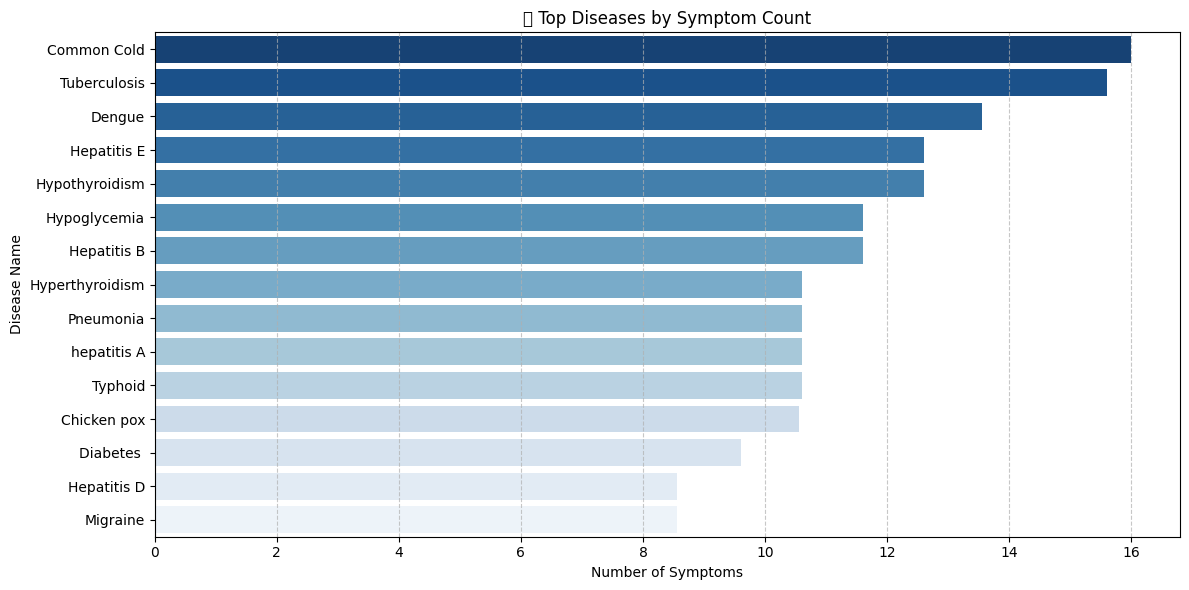

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Copy original dataset
data = desc_df.copy()

# Drop Disease column separately
disease_labels = data["Disease"]
symptom_cols = data.columns[1:-1]

# Count how many symptoms each disease has
data["symptom_count"] = data[symptom_cols].notna().sum(axis=1)

# Plot top 15 diseases by number of symptoms
plt.figure(figsize=(12, 6))
top_diseases = data.groupby("Disease")["symptom_count"].mean().sort_values(ascending=False).head(15)

sns.barplot(x=top_diseases.values, y=top_diseases.index, palette="Blues_r")
plt.title("🧠 Top Diseases by Symptom Count")
plt.xlabel("Number of Symptoms")
plt.ylabel("Disease Name")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [47]:
print(desc_df.columns.tolist())

['Disease', 'Symptom_1', 'Symptom_2', 'Symptom_3', 'Symptom_4', 'Symptom_5', 'Symptom_6', 'Symptom_7', 'Symptom_8', 'Symptom_9', 'Symptom_10', 'Symptom_11', 'Symptom_12', 'Symptom_13', 'Symptom_14', 'Symptom_15', 'Symptom_16', 'Symptom_17']


In [48]:
symptom_cols = [col for col in desc_df.columns if 'Symptom_' in col]
print("Detected symptom columns:", symptom_cols)


Detected symptom columns: ['Symptom_1', 'Symptom_2', 'Symptom_3', 'Symptom_4', 'Symptom_5', 'Symptom_6', 'Symptom_7', 'Symptom_8', 'Symptom_9', 'Symptom_10', 'Symptom_11', 'Symptom_12', 'Symptom_13', 'Symptom_14', 'Symptom_15', 'Symptom_16', 'Symptom_17']


In [49]:
desc_df[symptom_cols] = desc_df[symptom_cols].fillna("").applymap(lambda x: x.strip().lower())


/tmp/ipykernel_167779/2790507527.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  desc_df[symptom_cols] = desc_df[symptom_cols].fillna("").applymap(lambda x: x.strip().lower())


In [50]:
from collections import Counter

# Flatten all symptoms into one list
all_symptoms = desc_df[symptom_cols].values.ravel()
all_symptoms = [s for s in all_symptoms if s != ""]  # remove empty strings
symptom_counter = Counter(all_symptoms)

# Print top 10 most frequent symptoms
print("Top 10 symptoms:", symptom_counter.most_common(10))

# Create one-hot encoded columns
for symptom in symptom_counter.keys():
    desc_df[symptom] = desc_df[symptom_cols].apply(lambda row: symptom in row.values, axis=1)

# Drop original symptom columns
df_cleaned = desc_df.drop(columns=symptom_cols + ['Unnamed: 0'], errors='ignore')


Top 10 symptoms: [('fatigue', 1932), ('vomiting', 1914), ('high_fever', 1362), ('loss_of_appetite', 1152), ('nausea', 1146), ('headache', 1134), ('abdominal_pain', 1032), ('yellowish_skin', 912), ('yellowing_of_eyes', 816), ('chills', 798)]


/tmp/ipykernel_167779/1453938482.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  desc_df[symptom] = desc_df[symptom_cols].apply(lambda row: symptom in row.values, axis=1)
/tmp/ipykernel_167779/1453938482.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  desc_df[symptom] = desc_df[symptom_cols].apply(lambda row: symptom in row.values, axis=1)
/tmp/ipykernel_167779/1453938482.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

/tmp/ipykernel_167779/2726363631.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=symptom_freq.values, y=symptom_freq.index, palette="coolwarm")


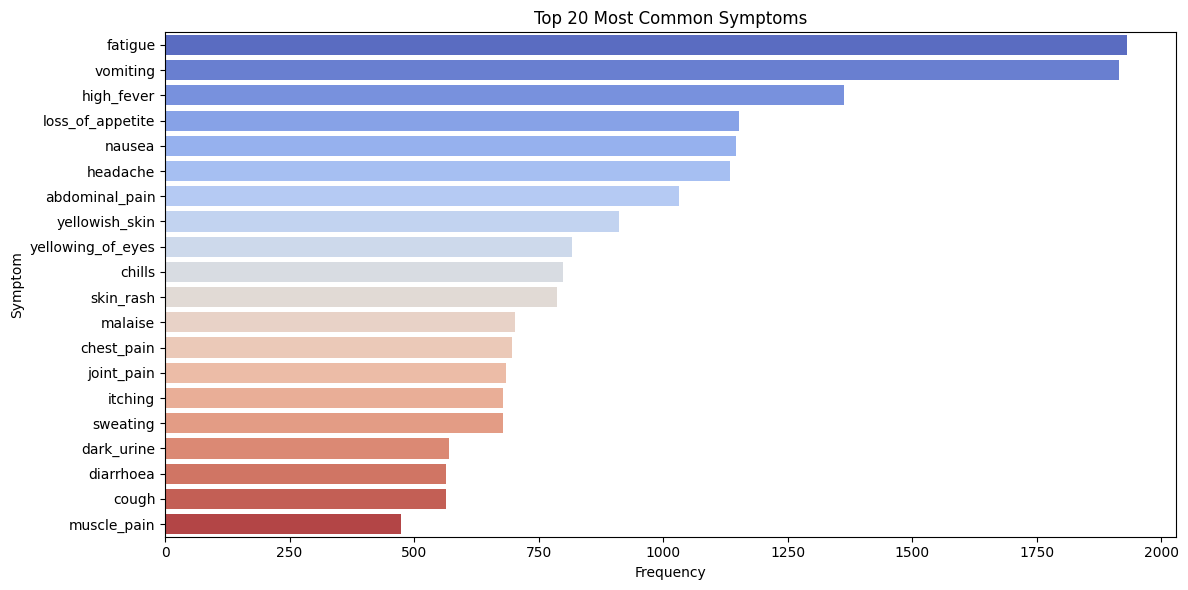

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sum of all symptom presence columns
symptom_freq = df_cleaned.iloc[:, 1:].sum().sort_values(ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x=symptom_freq.values, y=symptom_freq.index, palette="coolwarm")
plt.title("Top 20 Most Common Symptoms")
plt.xlabel("Frequency")
plt.ylabel("Symptom")
plt.tight_layout()
plt.show()


In [52]:
print(f"\n✅ Total unique symptoms encoded: {len(symptom_counter)}")
print("Sample symptoms:", list(symptom_counter.keys())[:10])



✅ Total unique symptoms encoded: 131
Sample symptoms: ['itching', 'skin_rash', 'nodal_skin_eruptions', 'dischromic _patches', 'continuous_sneezing', 'shivering', 'chills', 'watering_from_eyes', 'stomach_pain', 'acidity']


In [53]:
# Get top 10 most frequent diseases
top_diseases = df_cleaned['Disease'].value_counts().head(10).index.tolist()
df_top = df_cleaned[df_cleaned['Disease'].isin(top_diseases)]


In [54]:
# Group by disease and sum the binary symptom indicators
symptom_matrix = df_top.groupby('Disease').sum()


### 🔥 Heatmap of Symptom Frequency for Top 10 Diseases

This heatmap visualizes how frequently the top 15 symptoms occur across the 10 most common diseases in our dataset. It helps in understanding which symptoms are most strongly associated with which diseases.

- **Rows** represent the most common diseases.
- **Columns** are the most frequent symptoms.
- **Values** show how many times a symptom is present in cases of that disease.

This kind of visualization gives insight into symptom patterns that can help in disease prediction and model training.


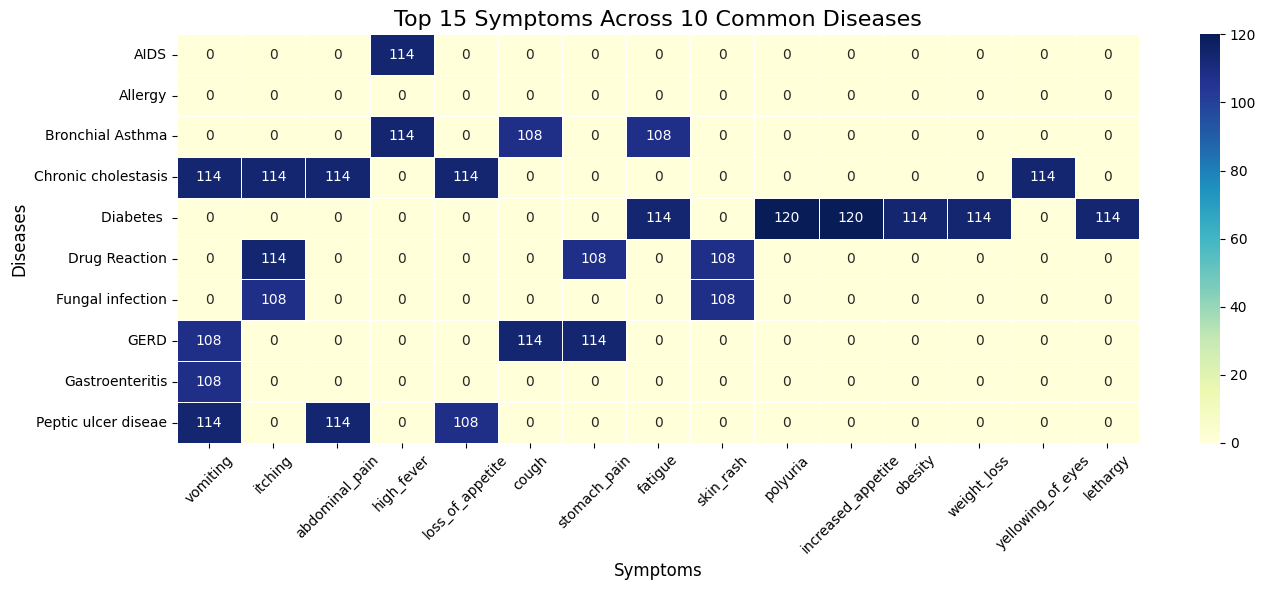

In [55]:
# Limit to top 15 symptoms for clarity
top_symptoms = symptom_matrix.sum().sort_values(ascending=False).head(15).index
plt.figure(figsize=(14, 6))
sns.heatmap(symptom_matrix[top_symptoms], cmap="YlGnBu", annot=True, fmt="d", linewidths=.5)

plt.title("Top 15 Symptoms Across 10 Common Diseases", fontsize=16)
plt.xlabel("Symptoms", fontsize=12)
plt.ylabel("Diseases", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 🧠 Label Encoding for Disease Column

Machine learning models require numeric input, so we convert the target labels (diseases) into numeric codes using `LabelEncoder`.

This step helps the model understand and learn from disease names efficiently.


In [56]:
from sklearn.preprocessing import LabelEncoder

# Initialize the encoder
label_encoder = LabelEncoder()

# Encode disease labels
df_cleaned["Disease_encoded"] = label_encoder.fit_transform(df_cleaned["Disease"])

# Display encoded mapping
disease_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("✅ Encoded disease mapping (sample):")
print(dict(list(disease_mapping.items())[:10]))  # show sample 10


✅ Encoded disease mapping (sample):
{'(vertigo) Paroymsal  Positional Vertigo': np.int64(0), 'AIDS': np.int64(1), 'Acne': np.int64(2), 'Alcoholic hepatitis': np.int64(3), 'Allergy': np.int64(4), 'Arthritis': np.int64(5), 'Bronchial Asthma': np.int64(6), 'Cervical spondylosis': np.int64(7), 'Chicken pox': np.int64(8), 'Chronic cholestasis': np.int64(9)}


/tmp/ipykernel_167779/3493714783.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cleaned["Disease_encoded"] = label_encoder.fit_transform(df_cleaned["Disease"])


### 🧪 Feature and Target Separation

Here, we separate the symptoms (`X`) from the target disease labels (`y`). This prepares the data for model training and evaluation.

- `X`: All the binary symptom features.
- `y`: The encoded disease label.


In [57]:
# X will be all binary symptom columns (0/1), y is the disease label
X = df_cleaned.drop(["Disease", "Disease_encoded"], axis=1)
y = df_cleaned["Disease_encoded"]

print("✅ Feature shape (X):", X.shape)
print("✅ Target shape (y):", y.shape)


✅ Feature shape (X): (4920, 131)
✅ Target shape (y): (4920,)


### 🔀 Step 3: Train-Test Split and Model Training (Random Forest)

Now we split the dataset into training and testing sets using `train_test_split`.

Then, we’ll use a **Random Forest Classifier**, which is excellent for classification problems and handles imbalanced/multiclass datasets well.

We'll also check the training accuracy after fitting the model.


In [58]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred = rf_model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Model Accuracy on Test Set: {accuracy:.4f}")


✅ Model Accuracy on Test Set: 1.0000


In [59]:
all_symptoms = list(X.columns)

### 📊 Step 4: Visualizing Model Evaluation

Let’s now visualize how well the model performs using:

- Confusion Matrix Heatmap
- Classification Report (Precision, Recall, F1-score)


/home/sharib-ahmad/.pyenv/versions/3.13.3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


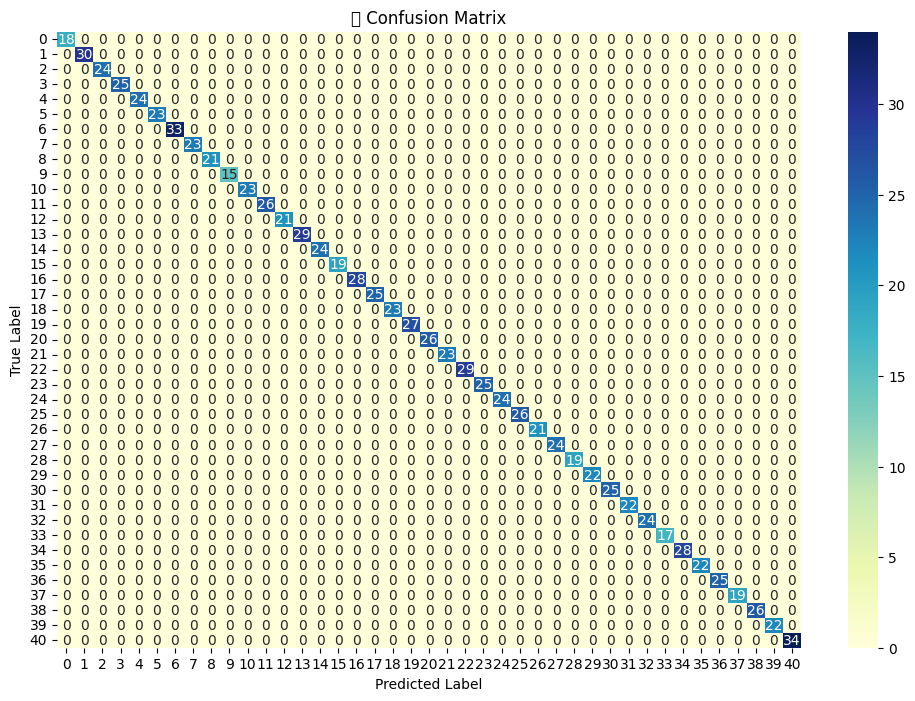

📄 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        30
           2       1.00      1.00      1.00        24
           3       1.00      1.00      1.00        25
           4       1.00      1.00      1.00        24
           5       1.00      1.00      1.00        23
           6       1.00      1.00      1.00        33
           7       1.00      1.00      1.00        23
           8       1.00      1.00      1.00        21
           9       1.00      1.00      1.00        15
          10       1.00      1.00      1.00        23
          11       1.00      1.00      1.00        26
          12       1.00      1.00      1.00        21
          13       1.00      1.00      1.00        29
          14       1.00      1.00      1.00        24
          15       1.00      1.00      1.00        19
          16       1.00      1.00      1.00        28
  

In [60]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu")
plt.title("📌 Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification report
print("📄 Classification Report:")
print(classification_report(y_test, y_pred))


### 🔍 Step 5: Feature Importance — Which Symptoms Matter Most?

We’ll now visualize which features (symptoms) contribute the most to predictions in our Random Forest model.


/tmp/ipykernel_167779/4254795030.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=feature_names, palette="magma")
/home/sharib-ahmad/.pyenv/versions/3.13.3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


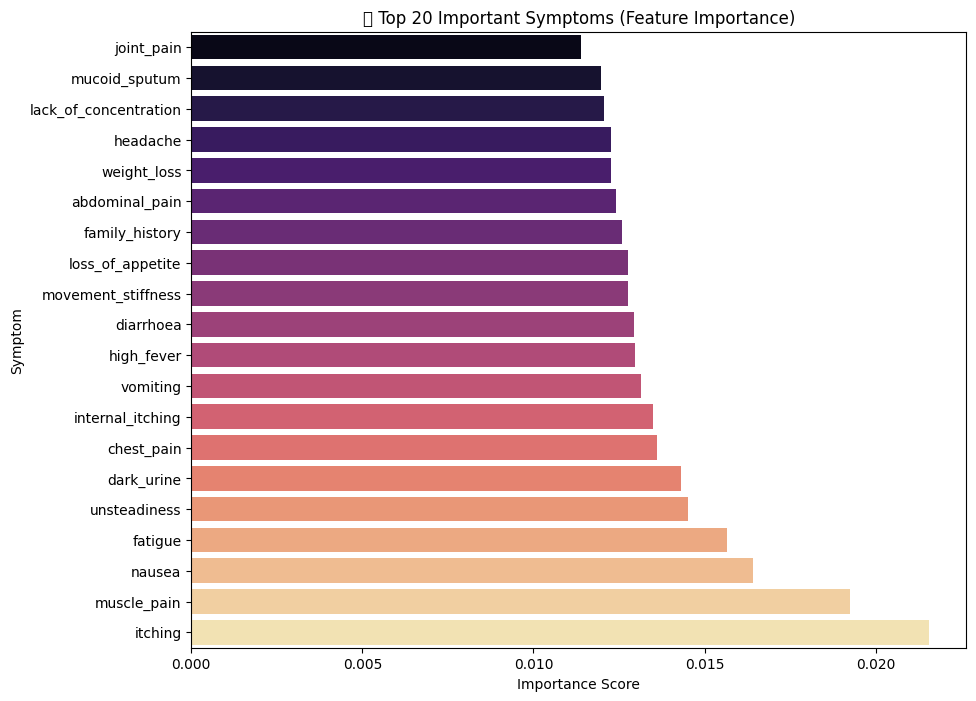

In [61]:
import numpy as np
# Feature importance from the trained model
importances = rf_model.feature_importances_
indices = np.argsort(importances)[-20:]  # Top 20 important symptoms
feature_names = X.columns[indices]

plt.figure(figsize=(10, 8))
sns.barplot(x=importances[indices], y=feature_names, palette="magma")
plt.title("💡 Top 20 Important Symptoms (Feature Importance)")
plt.xlabel("Importance Score")
plt.ylabel("Symptom")
plt.show()


### 💬 Step 6: Predicting Disease from Symptoms — Test it Live!

Now, let’s define a helper function that lets you enter symptoms and get a prediction instantly.


In [62]:
def predict_disease(symptoms_input):
    input_data = np.zeros(len(all_symptoms))

    for symptom in symptoms_input:
        symptom = symptom.strip().lower()
        for idx, known_symptom in enumerate(all_symptoms):
            if known_symptom.lower() == symptom:
                input_data[idx] = 1
                break
        else:
            print(f"⚠️ Symptom not recognized: {symptom}")

    input_df = pd.DataFrame([input_data], columns=all_symptoms)

    # Predict disease (encoded label)
    predicted_label = rf_model.predict(input_df)[0]

    # Decode to actual disease name
    predicted_disease = label_encoder.inverse_transform([predicted_label])[0]

    # Print prediction result
    from datetime import datetime
    print(f"📅 Prediction Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"🧍 Symptoms Entered: {', '.join(symptoms_input)}")
    print(f"🤖 Predicted Disease: **{predicted_disease}**")

    # Try getting precautions if available
    precautions = get_precautions(predicted_disease)
    if precautions.size > 0:
        print("\n💡 Precautions:")
        for i, p in enumerate(precautions, 1):
            print(f"  {i}. {p}")
    else:
        print("⚠️ No precautions found for this disease.")

    return predicted_disease


In [63]:
precautions_df = pd.read_csv("../datasets/symptom_precaution.csv")

def get_precautions(disease_name):
    row = precautions_df[precautions_df["Disease"].str.lower() == disease_name.lower()]
    if not row.empty:
        return row.values[0][1:]  # Skip the first column (Disease name)
    return []


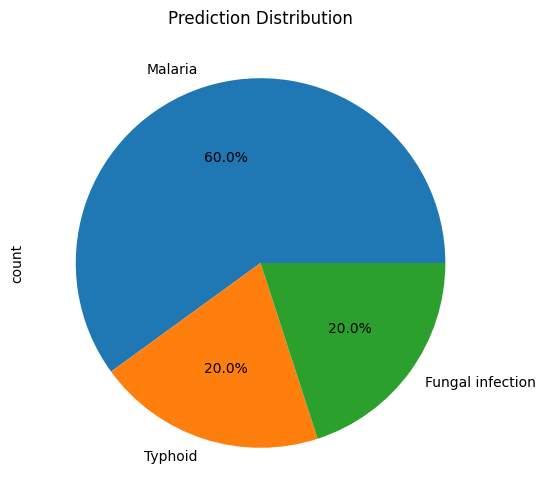

In [64]:
# Pie chart of all predictions done in session (if stored)
import matplotlib.pyplot as plt

# Example dummy data
disease_preds = ['Malaria', 'Typhoid', 'Malaria', 'Fungal infection', 'Malaria']
pd.Series(disease_preds).value_counts().plot.pie(autopct="%1.1f%%", figsize=(6,6))
plt.title("Prediction Distribution")
plt.show()


In [65]:
predict_disease(["chills", "headache", "muscle_pain"])


📅 Prediction Time: 2025-07-06 22:11:45
🧍 Symptoms Entered: chills, headache, muscle_pain
🤖 Predicted Disease: **Malaria**

💡 Precautions:
  1. Consult nearest hospital
  2. avoid oily food
  3. avoid non veg food
  4. keep mosquitos out


'Malaria'

In [66]:
print("Disease to Label Mapping:")
for disease, code in list(disease_mapping.items())[:10]:
    print(f"{disease:<25} -> {code}")


Disease to Label Mapping:
(vertigo) Paroymsal  Positional Vertigo -> 0
AIDS                      -> 1
Acne                      -> 2
Alcoholic hepatitis       -> 3
Allergy                   -> 4
Arthritis                 -> 5
Bronchial Asthma          -> 6
Cervical spondylosis      -> 7
Chicken pox               -> 8
Chronic cholestasis       -> 9


## 📊 Disease Frequency

Understanding the frequency of diseases in the dataset gives us insight into common and rare conditions, helping with model training balance and focus.


/tmp/ipykernel_167779/1562182384.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=disease_counts.values[:20], y=disease_counts.index[:20], palette="coolwarm")


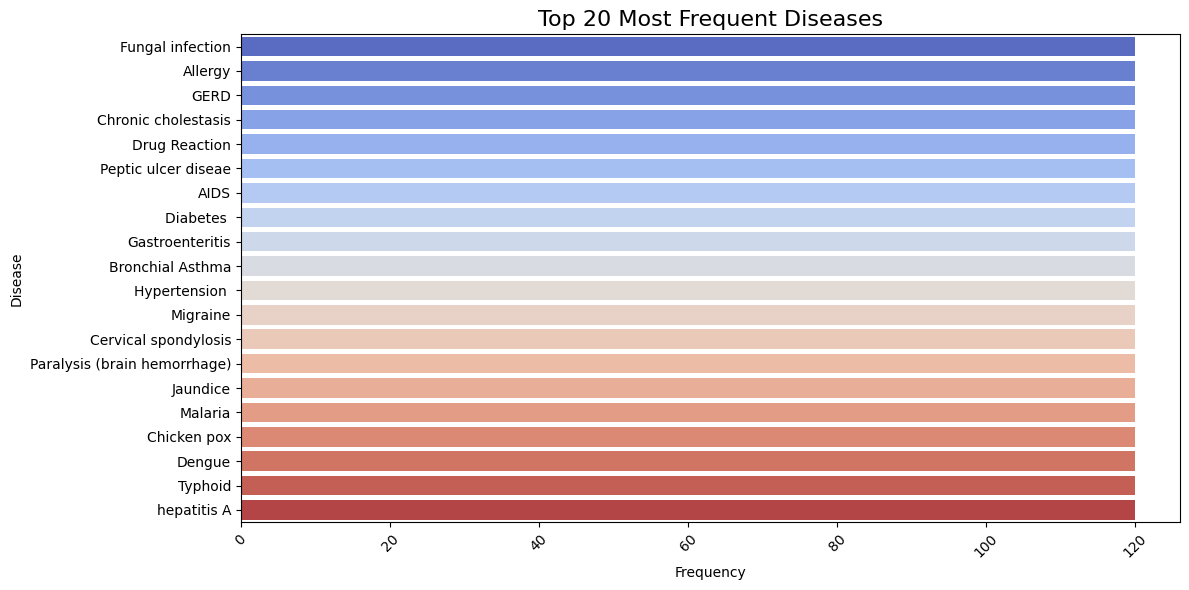

In [67]:
# Count frequency of each disease
disease_counts = df_cleaned["Disease"].value_counts().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=disease_counts.values[:20], y=disease_counts.index[:20], palette="coolwarm")
plt.title("Top 20 Most Frequent Diseases", fontsize=16)
plt.xlabel("Frequency")
plt.ylabel("Disease")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 💬 Symptom Occurrence

Visualizing the most common symptoms helps identify overlapping or misleading symptoms that could affect model accuracy.


/tmp/ipykernel_167779/644372979.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=symptom_frequency.values[:20], y=symptom_frequency.index[:20], palette="YlGnBu")


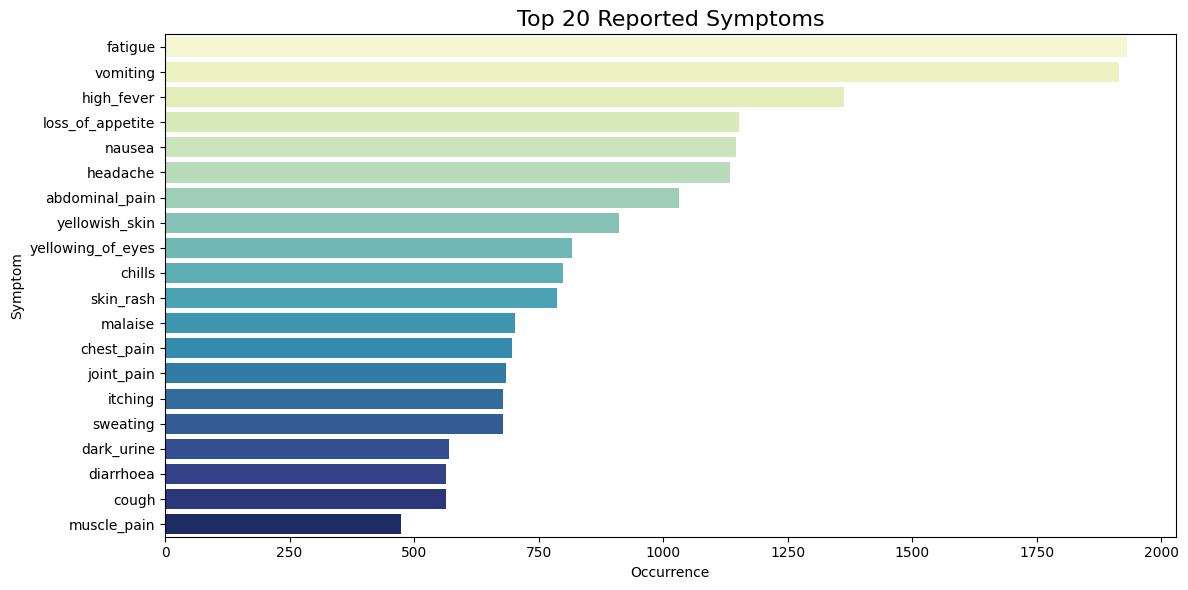

In [68]:
# Drop non-binary or text columns and sum occurrences
binary_symptom_cols = df_cleaned.columns[1:-1]  # assuming 1st col is 'Disease' and last is 'Disease_encoded'
symptom_frequency = df_cleaned[binary_symptom_cols].sum().sort_values(ascending=False)

# Plot top 20 symptoms
plt.figure(figsize=(12, 6))
sns.barplot(x=symptom_frequency.values[:20], y=symptom_frequency.index[:20], palette="YlGnBu")
plt.title("Top 20 Reported Symptoms", fontsize=16)
plt.xlabel("Occurrence")
plt.ylabel("Symptom")
plt.tight_layout()
plt.show()


## 🔥 Symptom Co-Occurrence (Correlation Heatmap)

Some symptoms often occur together. This correlation heatmap helps us visualize such patterns.


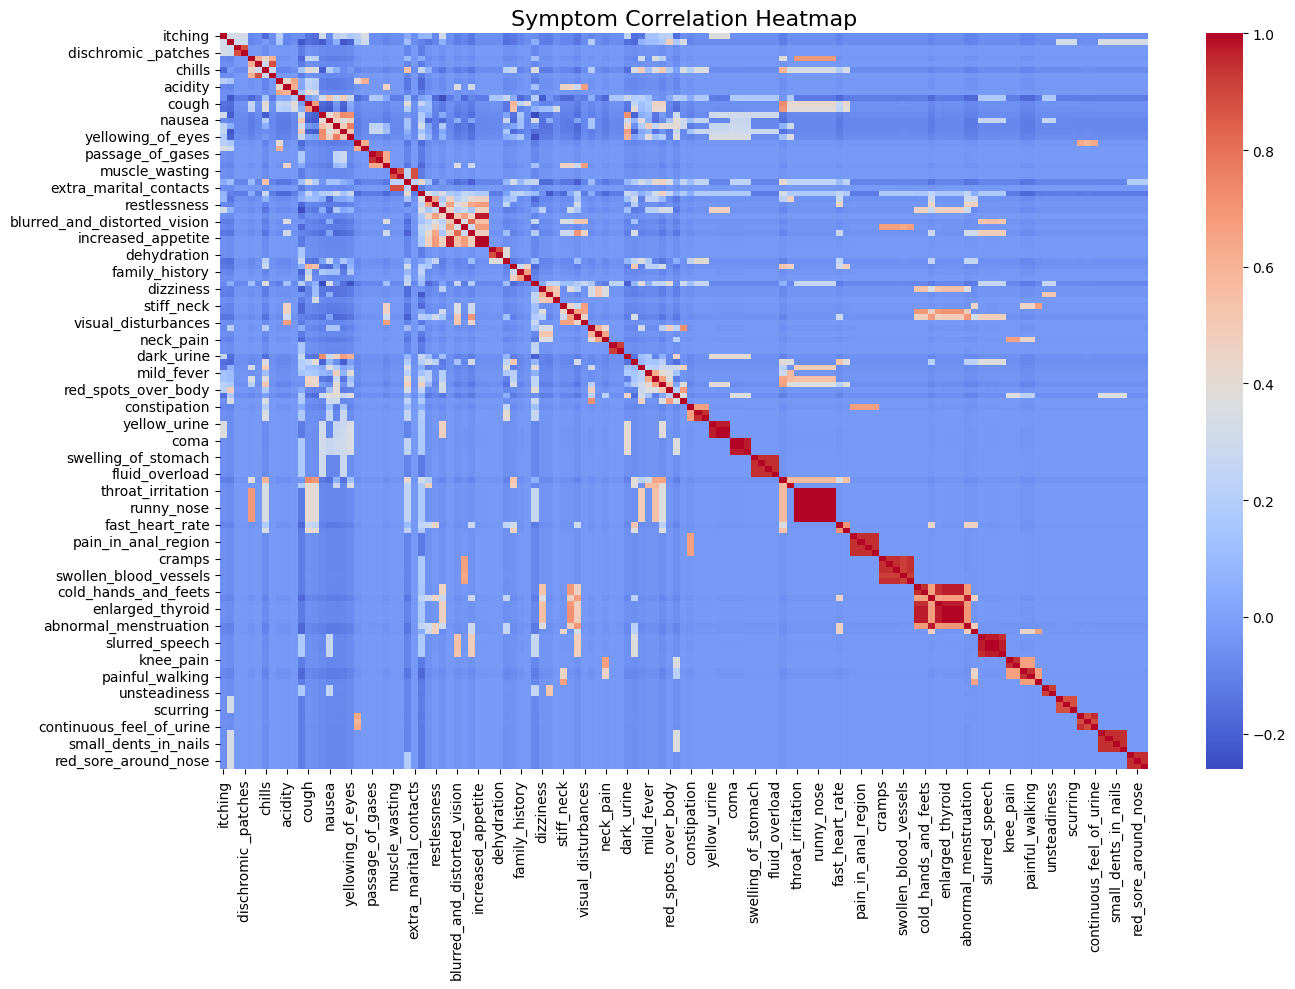

In [69]:
# Compute correlation
correlation = df_cleaned[binary_symptom_cols].corr()

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation, cmap='coolwarm', cbar=True)
plt.title("Symptom Correlation Heatmap", fontsize=16)
plt.tight_layout()
plt.show()


## ✅ Model Evaluation Metrics

To understand how well our disease prediction model performs, we use the following metrics:
- **Accuracy**: Overall, how often is the model correct?
- **Precision**: When the model predicts a disease, how often is it right?
- **Recall**: How well does the model find all the true cases?
- **F1-Score**: Balance between precision and recall.

We’ll evaluate on the test dataset using these metrics.


In [70]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Predict on test set
y_pred = rf_model.predict(X_test)

# Display evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="macro")
recall = recall_score(y_test, y_pred, average="macro")
f1 = f1_score(y_test, y_pred, average="macro")

print("✅ Model Performance on Test Set")
print(f"🔹 Accuracy:  {accuracy:.4f}")
print(f"🔹 Precision: {precision:.4f}")
print(f"🔹 Recall:    {recall:.4f}")
print(f"🔹 F1 Score:  {f1:.4f}")


✅ Model Performance on Test Set
🔹 Accuracy:  1.0000
🔹 Precision: 1.0000
🔹 Recall:    1.0000
🔹 F1 Score:  1.0000


## 📋 Classification Report

Below is a class-wise breakdown of performance showing precision, recall, and F1-score for each disease.


In [71]:
# Show classification report for detailed view
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        18
                                   AIDS       1.00      1.00      1.00        30
                                   Acne       1.00      1.00      1.00        24
                    Alcoholic hepatitis       1.00      1.00      1.00        25
                                Allergy       1.00      1.00      1.00        24
                              Arthritis       1.00      1.00      1.00        23
                       Bronchial Asthma       1.00      1.00      1.00        33
                   Cervical spondylosis       1.00      1.00      1.00        23
                            Chicken pox       1.00      1.00      1.00        21
                    Chronic cholestasis       1.00      1.00      1.00        15
                            Common Cold       1.00      1.00      1.00        23
                           

# Check for duplicate rows
duplicates = df_cleaned.duplicated().sum()
print(f"🔍 Duplicate rows: {duplicates}")


/tmp/ipykernel_167779/2013510506.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[sorted_idx], y=features[sorted_idx], palette="coolwarm")
/tmp/ipykernel_167779/2013510506.py:15: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/sharib-ahmad/.pyenv/versions/3.13.3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


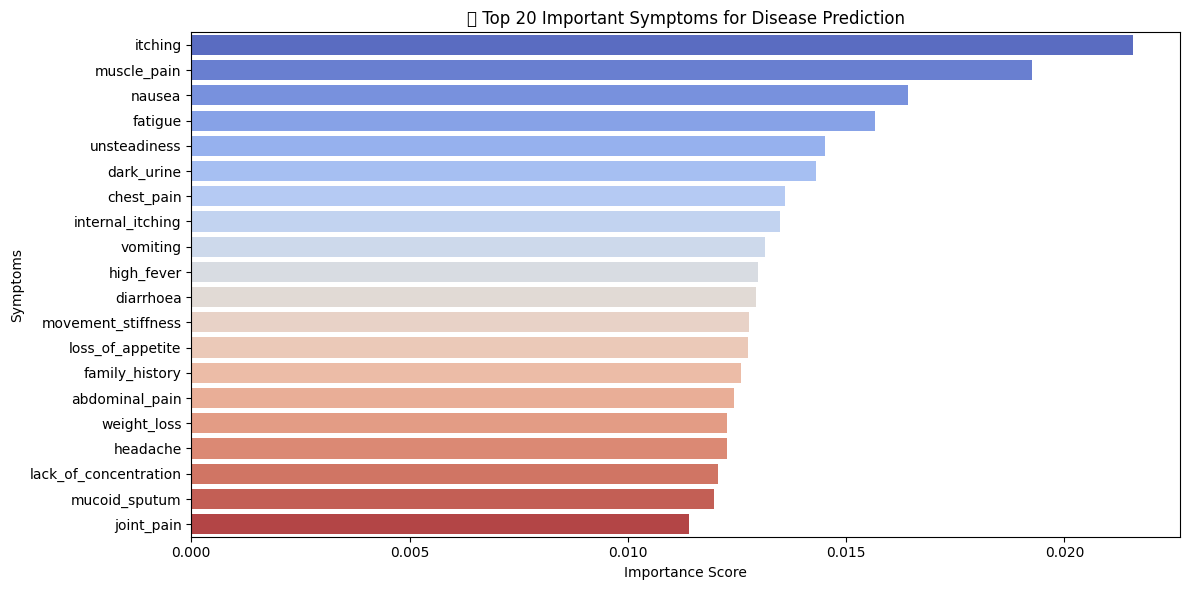

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances
importances = rf_model.feature_importances_
features = X.columns

# Sort and visualize top 20 features
sorted_idx = importances.argsort()[::-1][:20]
plt.figure(figsize=(12, 6))
sns.barplot(x=importances[sorted_idx], y=features[sorted_idx], palette="coolwarm")
plt.title("🌟 Top 20 Important Symptoms for Disease Prediction")
plt.xlabel("Importance Score")
plt.ylabel("Symptoms")
plt.tight_layout()
plt.show()


### 💾 Step 7: Saving the Model

We’ll now save the trained model and the list of all symptoms so they can be used in your Flask app.


In [73]:
import joblib

joblib.dump(rf_model, "../datasets/disease_model.pkl")
joblib.dump(label_encoder, "../datasets/label_encoder.pkl")

print("✅ Model and symptom list saved successfully!")


✅ Model and symptom list saved successfully!


In [74]:
# Save the exact SYMPTOM_LIST used in training
with open("../bot/symptom_list.txt", "w") as f:
    for s in all_symptoms:
        f.write(s + "\n")

print("✅ SYMPTOM_LIST saved.")

✅ SYMPTOM_LIST saved.
